In [91]:
import os
from os import path
import sys

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits, ascii
import astropy.units as u
import emcee
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.stats import truncnorm
from schwimmbad import MultiPool, SerialPool

import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

# This project:
from potential import default_mw
from coordinates import (pal5_c, galcen_frame,
                         pal5_lead_frame, pal5_trail_frame)

from potential import get_bar_model
from coordinates import pal5_M

plot_path = path.abspath('../plots')
os.makedirs(plot_path, exist_ok=True)

## Read in bar models from cluster run

In [92]:
##Read in bar models
bar5e9 = gd.PhaseSpacePosition.from_hdf5('BarModels_RL1_Mb5e+09_Om38.0.hdf5')
bar1e10 = gd.PhaseSpacePosition.from_hdf5('BarModels_RL1_Mb1e+10_Om45.0.hdf5')

In [93]:
#sim_c_bar5e9 = bar5e9.to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)
#sim_c_bar1e10 = bar1e10.to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)
sim_c_bar5e9 = bar5e9.to_coord_frame(gc.Pal5PriceWhelan18, galactocentric_frame=galcen_frame)
sim_c_bar1e10 = bar1e10.to_coord_frame(gc.Pal5PriceWhelan18, galactocentric_frame=galcen_frame)

## Run reg. and chaotic orbits

In [94]:
mw = default_mw

pot_flat = gp.CCompositePotential()
pot_flat['halo'] = gp.NFWPotential(m = mw['halo'].parameters['m'],
                                  r_s = mw['halo'].parameters['r_s'],
                                  c = 0.5, units=galactic)
pot_flat['disk'] = mw['disk']
pot_flat['bulge'] = mw['bulge']

pot_reg = mw

  #  pot = gp.CCompositePotential()
  #  pot['disk'] = default_mw['disk']
  #  pot['halo'] = 
  #  pot['bar'] = get_bar_model(Omega=omega, Snlm=S, m=m_b)

In [151]:
#pal5_c
pal5_M

<Quantity 14404. solMass>

In [96]:
w0 = gd.PhaseSpacePosition(pal5_c.transform_to(galcen_frame).cartesian)

release_every=1 
n_particles=1
dt=-1 
n_steps=6000
    
df = gd.FardalStreamDF(random_state=np.random.RandomState(42))

H = gp.Hamiltonian(pot_flat)
prog_pot = gp.PlummerPotential(pal5_M, 4*u.pc, units=galactic)
gen = gd.MockStreamGenerator(df = df, hamiltonian = H,
                                 progenitor_potential = prog_pot)

stream_data, _ = gen.run(w0, pal5_M,
                             dt=dt, n_steps=n_steps,
                             release_every=release_every,
                             n_particles=n_particles)

#cache_file = 'BarModels_RL{:d}_Mb{:.0e}_Om{:.1f}.hdf5'.format(release_every, m_b.value, omega.value)
#if path.exists(cache_file):
#    os.unlink(cache_file)
#stream_data.to_hdf5(cache_file)
sim_c_flat = stream_data.to_coord_frame(gc.Pal5PriceWhelan18,
                                       galactocentric_frame=galcen_frame)
  

In [97]:
##regular orbit  

H_reg = gp.Hamiltonian(pot_reg)
prog_pot = gp.PlummerPotential(pal5_M, 4*u.pc, units=galactic)
gen_reg = gd.MockStreamGenerator(df = df, hamiltonian = H_reg,
                                 progenitor_potential = prog_pot)

stream_data_reg, _ = gen_reg.run(w0, pal5_M,
                             dt=dt, n_steps=n_steps,
                             release_every=release_every,
                             n_particles=n_particles)

#cache_file = 'BarModels_RL{:d}_Mb{:.0e}_Om{:.1f}.hdf5'.format(release_every, m_b.value, omega.value)
#if path.exists(cache_file):
#    os.unlink(cache_file)
#stream_data.to_hdf5(cache_file)
sim_c_reg = stream_data_reg.to_coord_frame(gc.Pal5PriceWhelan18,
                                       galactocentric_frame=galcen_frame)
  

## Make figure for plot of sim output

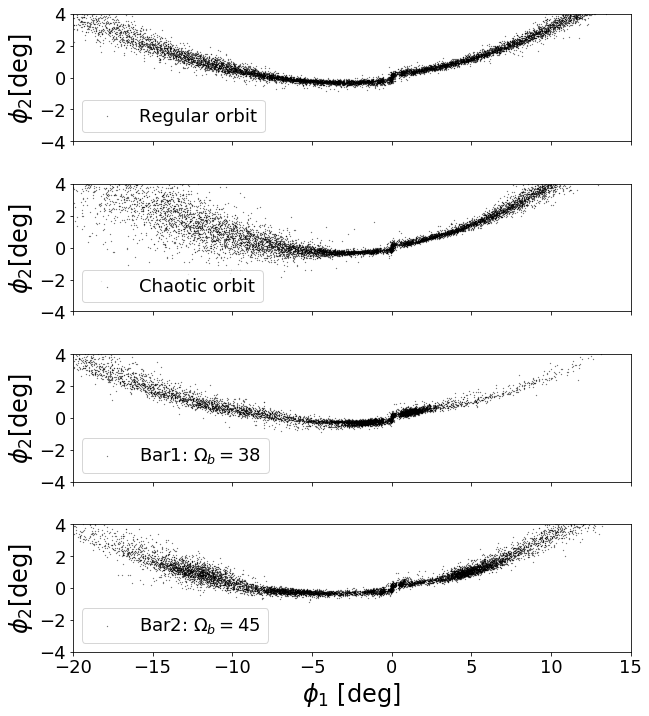

In [149]:

fig,axes = plt.subplots(4,1,figsize=(10,12), sharex=True, sharey = True)

mpl.rcParams.update({'font.size': 24})
label_size = 24
mpl.rcParams['xtick.labelsize'] = 18#label_size 
mpl.rcParams['ytick.labelsize'] =18 #label_size 

axes[0].scatter(sim_c_reg.phi1, sim_c_reg.phi2,s=0.05,color='black', label='Regular orbit', rasterized=True)
axes[0].set_xlim(-20,15)
axes[0].set_ylim(-4,4)
axes[0].set_aspect('equal')
#axes[0,0].set_xlabel('$\phi_1$ [deg]')
axes[0].set_ylabel('$\phi_2$[deg]')
axes[0].legend(loc='lower left', fontsize=18)
#axes[1,0].set_title('Regular orbit') #make sure I grab correct Om. 

axes[1].scatter(sim_c_flat.phi1, sim_c_flat.phi2,s=0.05,color='black', label='Chaotic orbit', rasterized=True)
axes[1].set_xlim(-20,15)
axes[1].set_ylim(-4,4)
axes[1].set_yticks([-4,-2,0,2,4])
axes[1].set_aspect('equal')
axes[1].legend(loc='lower left', fontsize=18)
#axes[0,1].set_xlabel('$\phi_1$ [deg]')
axes[1].set_ylabel('$\phi_2$[deg]')
#axes[1,1].set_title('Chaotic orbit') #make sure I grab correct Om. 


axes[2].scatter(sim_c_bar5e9.phi1, sim_c_bar5e9.phi2,s=0.05, color='black', label='Bar1: $\Omega_b = 38$', rasterized=True)
axes[2].set_xlim(-20,15)
axes[2].set_ylim(-4,4)
axes[2].set_aspect('equal')
#axes[2].set_xlabel('$\phi_1$ [deg]')
axes[2].set_ylabel('$\phi_2$[deg]')
axes[2].legend(loc='lower left', fontsize=18)
#axes[1,0].set_title('Regular orbit') #make sure I grab correct Om. 

axes[3].scatter(sim_c_bar1e10.phi1, sim_c_bar1e10.phi2,s=0.05, color='black', label='Bar2: $\Omega_b = 45$',rasterized=True)
axes[3].set_xlim(-20,15)
axes[3].set_ylim(-4,4)
axes[3].set_aspect('equal')
axes[3].set_xlabel('$\phi_1$ [deg]')
axes[3].legend(loc='lower left', fontsize=18)
axes[3].set_ylabel('$\phi_2$[deg]')
#axes[1,1].set_title('Chaotic orbit') #make sure I grab correct Om. 
    
#fig.tight_layout()
#fig.savefig('/Users/spearson/Dropbox/AnaPal5/Fig4_Sims.pdf',dpi=200, rastorized=True)
fig.savefig('/Users/spearson/Desktop/Pal5sBiggestFan/paper/Fig4_Sims.pdf',dpi=200, rastorized=True)